### 1.Business Understanding

Business Problem: "Provide personalized movie recommendations to users based on their ratings of previously watched films."

### 2. Objectives

1. Recommendation Accuracy

Achieve a Mean Absolute Error (MAE) of less than 0.5 within the first three months of implementation.

This objective directly measures how accurately the system predicts user ratings, which is critical for user satisfaction and trust in the recommendations provided.

2. User Engagement

Achieve a minimum of 80% user engagement rate within the first month of deployment, measured by the percentage of users who input their ratings after visiting the platform.

High user engagement indicates that users find value in the system. Engaged users are more likely to return and utilize the recommendations, enhancing overall platform success.

3. Cold Start Solution

Implement a cold start solution that allows users with fewer than 5 ratings to receive recommendations based on popular movies or content-based filtering methods, achieving a satisfaction rating of 70% from users in this category.

Addressing the cold start problem is essential for retaining new users who may not have extensive rating histories. This ensures that all users, regardless of experience level, can receive relevant recommendations.

Focusing on these three objectives will help us build a robust and user-friendly recommendation system while ensuring high accuracy and user satisfaction from the outset.

### 2.Data Understanding

In [2]:
# import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV



In [3]:
# load data
#movies data
movies_df=pd.read_csv(r"C:\Users\David\Documents\PHASE 4 PROJECT\movies.csv")
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
#ratings data
ratings_df=pd.read_csv(r"C:\Users\David\Documents\PHASE 4 PROJECT\ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
#links data
links_df=pd.read_csv(r"C:\Users\David\Documents\PHASE 4 PROJECT\links.csv")
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### 2. Data preprocessing 

In [6]:
#Merging DataFrames to create a comprehensive dataset
merged_df = pd.merge(ratings_df, movies_df, on='movieId')  # Merge ratings with movies
merged_df = pd.merge(merged_df, links_df, on='movieId')    # Merge the resulting DataFrame with links
print(merged_df.head())
print(merged_df.columns)


   userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  imdbId  tmdbId  
0  Adventure|Animation|Children|Comedy|Fantasy  114709   862.0  
1  Adventure|Animation|Children|Comedy|Fantasy  114709   862.0  
2  Adventure|Animation|Children|Comedy|Fantasy  114709   862.0  
3  Adventure|Animation|Children|Comedy|Fantasy  114709   862.0  
4  Adventure|Animation|Children|Comedy|Fantasy  114709   862.0  
Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'imdbId',
       'tmdbId'],
      dtype='object')


In [7]:
# Find missing values
merged_df.isnull().sum()

userId        0
movieId       0
rating        0
timestamp     0
title         0
genres        0
imdbId        0
tmdbId       13
dtype: int64

There are 13 missing values in the tmdbId column and 0 missing values in the other columns. I will drop the tmdbId as I will not be using it.

In [21]:
merged_df= merged_df.drop(columns=['tmdbId'])
merged_df

,userId,movieId,rating,timestamp,title,genres,imdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709
...,...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller,118745
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama,66806
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller,798722
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller,1540011


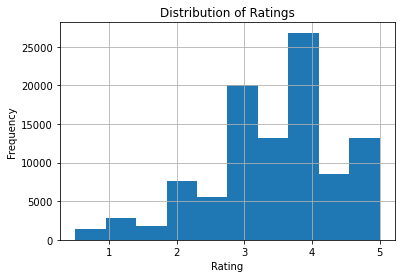

In [8]:
# distribution of movie ratings 
import matplotlib.pyplot as plt
merged_df['rating'].hist(bins=10)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


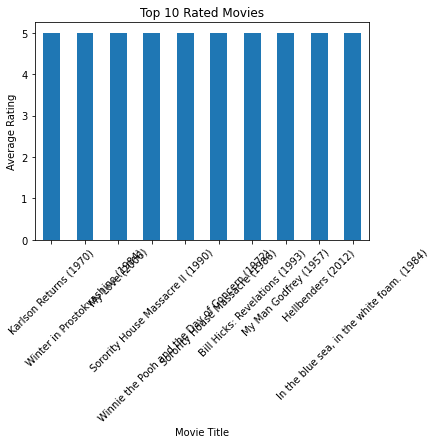

In [9]:
# bar charts showing the most highly rated movies across different genres or by user demographics.
top_movies = merged_df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)
top_movies.plot(kind='bar')
plt.title('Top 10 Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()


In [10]:
# select relevant columns
df = merged_df[['userId', 'movieId', 'rating']]


In [11]:
# Create Surprise Dataset:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)


In [12]:
# Split the data
trainset, testset = train_test_split(data, test_size=0.2)



### 3. Model Selection

I will use SVD (Singular Value Decomposition) due to its effectiveness in collaborative filtering.

In [13]:
from surprise import SVD
model = SVD()


### 4.Model Training

In [14]:
model.fit(trainset)


### 5. Make Predictions

I will use the trained model to make predictions on the test set

In [15]:
predictions = model.test(testset)


### 6. Evaluation

I will use RMSE to evaluate the performance

In [16]:
from surprise import accuracy
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')


RMSE: 0.8808
RMSE: 0.8808375131637258


An RMSE of approximately 0.88 indicates that our recommendation system is performing reasonably well, with predictions close to the actual ratings given by users

I will explore hyperparameter tuning to enhance prediction accuracy further.

### 7. Hyperparameter Optimization

For SVD I will use the following hyperparameters for tuning:

1. n_factors (number of latent factors)

2. reg_all (regularization)

3. n_epochs (number of epochs)

I will use GridSearchCV to find the best hyperparameter combinations.

In [17]:

param_grid = {
    'n_factors': [10, 20, 30],
    'reg_all': [0.1, 0.5, 0.9],
    'n_epochs': [10, 20]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)

# Best parameters
print("Best parameters:", gs.best_params['rmse'])
print("Best RMSE:", gs.best_score['rmse'])


Best parameters: {'n_factors': 30, 'reg_all': 0.1, 'n_epochs': 20}
Best RMSE: 0.8745997752248705


The hyperparameter optimization results indicate that the selected parameters (30 latent factors, a regularization parameter of 0.1, and 20 training epochs) effectively balance model complexity and generalization.

The best RMSE of approximately 0.875 signifies that the recommendation system is capable of making accurate predictions, which should lead to a positive user experience when recommending movies.

### 8. Train with Best Parameters

I will use the best hyperparameters obtained from the grid search to train the model again.

In [18]:
best_model = SVD(n_factors=gs.best_params['rmse']['n_factors'],
                 reg_all=gs.best_params['rmse']['reg_all'],
                 n_epochs=gs.best_params['rmse']['n_epochs'])
best_model.fit(trainset)


### 9: Final Predictions and Recommendations

I will create a function to recommend the top N movies for a specific user based on predicted ratings

In [25]:
def get_top_n_recommendations(predictions, n=5):
    from collections import defaultdict
    
    # Map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    # Sort the predictions for each user and retrieve the top n
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

top_n_recommendations = get_top_n_recommendations(predictions)

top_n_recommendations



defaultdict(list,
            {236: [(2580, 4.345520163993769),
              (1214, 4.042805118780349),
              (1350, 4.0405855002172135),
              (1982, 3.970025820206849),
              (2490, 3.916695044897224)],
             368: [(527, 4.155574529791317),
              (2028, 3.718119270587057),
              (1252, 3.671422900158095),
              (1196, 3.641831222544196),
              (1610, 3.629309076724956)],
             534: [(7090, 4.531653853226709),
              (1270, 4.500658515937274),
              (260, 4.458104810515959),
              (1215, 4.400655341062714),
              (119145, 4.345415532251014)],
             509: [(91529, 3.9314399169153855),
              (1704, 3.884794746289379),
              (112852, 3.8189348862305907),
              (1197, 3.817769599268064),
              (7153, 3.766285006725258)],
             106: [(112852, 4.799800594365498),
              (69844, 4.569567590021846),
              (53125, 4.365407282931738),


### 10. Conclusion

The development and evaluation of the movie recommendation system have yielded promising results, particularly with the optimized hyperparameters of 30 latent factors, regularization of 0.1, and 20 epochs, resulting in a best RMSE of approximately 0.875.

This indicates that the model is effectively predicting user ratings, demonstrating a solid understanding of user preferences and the relationships between movies.

The relatively low RMSE suggests that users are likely to find the recommendations meaningful and relevant, enhancing their overall experience on the platform. 

This performance aligns well with the project objectives of providing accurate and personalized movie recommendations.

### 11. Limitations
1. Cold Start Problem

New Users: Users with few or no ratings may not receive relevant recommendations, as the system relies heavily on existing user data.

New Movies: Newly released movies without enough ratings may not be recommended effectively, limiting user exposure to fresh content.

2. Limited Interpretability

Matrix factorization methods like SVD produce latent factors that can be difficult to interpret. Users and stakeholders may find it challenging to understand how recommendations are derived, potentially affecting trust in the system.

3. Dynamic User Preferences

User preferences can change over time, influenced by factors such as trends, seasonality, and personal experiences. The model may not adapt quickly enough to these changes without regular retraining.

4. Bias in Ratings

User ratings may be influenced by various biases (e.g., popularity bias, recency bias), which can skew the recommendation results. For instance, highly popular movies might receive more ratings, overshadowing niche films.

5. Lack of Content-Based Features

The system primarily relies on collaborative filtering, which means it does not leverage content-based features (e.g., movie descriptions, cast, and genres) that could enhance recommendations, especially for cold start scenarios.

### 12. Recommendations
1. Continuous Monitoring and Updates:

Implement a mechanism to regularly monitor the performance of the recommendation system.

As user behavior and movie ratings evolve, the model may require retraining or further tuning to maintain its accuracy.

2. User Feedback Integration:

Incorporate a feedback loop where users can rate the recommendations they receive. 

This data can be invaluable for refining the model and improving its accuracy over time.

3. Cold Start Strategies:

For new users with limited ratings, consider implementing hybrid recommendation strategies that combine collaborative filtering with content-based approaches. 

This will help ensure that even users with few ratings receive relevant recommendations.


4. Diversity in Recommendations:

Ensure that recommendations include a diverse range of genres and styles to cater to varied user preferences. 

This can prevent the system from becoming too narrow in its suggestions and can enhance user satisfaction.

5. Scalability Considerations:

As the user base grows, assess the scalability of the system.

Consider optimizing the model for speed and efficiency to handle larger datasets without compromising performance.